# 2D quasilinear diffusion equation for pressure (Pt=(k(P)Px)x) and Finite Element Method for Oil Well Production Forecasting

(Well and geometric parameters changed - NDA) Instructions for running the program:  
1. Install the libraries: `fipy`, `matplotlib`  
2. Enter data in the "Input Data" block  
3. Run all blocks of the program sequentially

# Input Data

In [3]:
#----------------------------------------------------------------
#----------------Block for entering model input parameters-------
#----------------------------------------------------------------
k_Frac = 2*10**(-13) # Permeability in the fracture
k_SRV = 2*10**(-18)  # Permeability in the SRV zone
k_Matrix = 2*10**(-19) # Permeability in the matrix

m = 0.05 # Porosity
C = 2.5*10**(-9) # Total compressibility
mu = 0.5*10**(-3) # Fluid viscosity
H = 35 # Fracture height
Pstart = 230*100000 # Initial reservoir pressure
Pwell = 50*100000 # Well pressure
D_SRV = k_SRV/(mu*m*C) # Calculation of the diffusivity coefficient in the SRV zone
D_Matrix = k_Matrix/(mu*m*C) # Calculation of the diffusivity coefficient in the matrix
D_Frac = k_Frac/(mu*m*C) # Calculation of the diffusivity coefficient in the fracture

# Сomputation

In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fipy as fp # Solver library
from fipy.tools import numerix
import matplotlib.pyplot as plt # For visualization
from fipy import CellVariable, Gmsh2D, TransientTerm, DiffusionTerm, Viewer
from fipy.tools import numerix
from fipy.viewers.matplotlibViewer.matplotlib2DGridContourViewer import Matplotlib2DGridContourViewer as Viewer

In [9]:
#----------------------------------------------------------------
#----------------------Grid and Geometry Setup Block-------------
#----------------------------------------------------------------
# Grid parameters
# Fracture
nx_Frac = 7 # Discretization along the x-coordinate
ny_Frac = 800 # Discretization along the y-coordinate
dx_Frac = 0.001 # Cell width along the x-coordinate
dy_Frac = 1 # Cell width along the y-coordinate

# SRV Zone (size nx_SRV*dx_SRV x ny_SRV*dy_SRV)
nx_SRV = 10
ny_SRV = 800
dx_SRV = 0.2
dy_SRV = 1

# Lateral part of the matrix zone (untouched by fracturing)
nx_MatrixLateral = 15
ny_MatrixLateral = 800
dx_MatrixLateral = 0.2
dy_MatrixLateral = 1

# Grid initialization
# Grid for the left lateral part of the untouched matrix zone
MatrixLateralLeftMesh = fp.Grid2D(dx=dx_MatrixLateral, 
                                  dy=dy_MatrixLateral, 
                                  nx=nx_MatrixLateral, 
                                  ny=ny_MatrixLateral)        
# Grid for the left wing of the SRV
SrvLeftMesh =(fp.Grid2D(dx=dx_SRV, 
          dy=dy_SRV, 
          nx=nx_SRV, 
          ny=ny_SRV)+((dx_MatrixLateral*nx_MatrixLateral,),(0,)))
# Grid inside the fracture
FracMesh = (((dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV,), (0,)) 
+ fp.Grid2D(dx=dx_Frac, 
            dy=dy_Frac, 
            nx=nx_Frac, 
            ny=ny_Frac))
# Grid for the right wing of the SRV
SrvRightMesh =(((dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV+nx_Frac*dx_Frac,), (0,))
    +fp.Grid2D(dx=dx_SRV, 
          dy=dy_SRV, 
          nx=nx_SRV, 
          ny=ny_SRV))
# Grid for the right lateral part of the untouched matrix zone
MatrixLateralRightMesh = (((dx_MatrixLateral*nx_MatrixLateral+2*dx_SRV*nx_SRV+nx_Frac*dx_Frac,), (0,)) 
+ fp.Grid2D(dx=dx_MatrixLateral, 
            dy=dy_MatrixLateral, 
            nx=nx_MatrixLateral, 
            ny=ny_MatrixLateral))
# Combine all grids
mesh = (MatrixLateralLeftMesh + SrvLeftMesh + FracMesh+SrvRightMesh+MatrixLateralRightMesh)


#----------------------------------------------------------------
#----------------------Initial and Boundary Conditions Setup-----
#----------------------------------------------------------------
# Define the solution variable
phi = fp.CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = Pstart) 

# Coordinates of the start and end of the fracture along the x-axis
FracXcoordStart = dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV
FracXcoordFinish = dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV+nx_Frac*dx_Frac
# Coordinates of the start and end of the fracture along the y-axis
FracYcoordStart = 200
FracYcoordFinish = 600
# Coordinates of the middle of the fracture along the y-axis
FracYcoordMedium = 400

X, Y = mesh.faceCenters # Arrays of cell face coordinates
x, y = mesh.cellCenters # Arrays of cell center coordinates
# Arrays defining whether a face/cell belongs to the well
Fracfaces = (X >= FracXcoordStart) & (X <= FracXcoordFinish) & (Y >= FracYcoordMedium-1) & (Y < FracYcoordMedium+1)
FracCell = (x > FracXcoordStart) & (x < FracXcoordFinish) & (y > FracYcoordMedium-1) & (y < FracYcoordMedium+1)

# Set initial and boundary pressure in the "well"
phi.setValue(Pwell, where=FracCell) 
phi.constrain(Pwell, Fracfaces)


#----------------------------------------------------------------
#------------------Diffusivity Coefficient Setup Block-----------
#----------------------------------------------------------------
# Define the diffusivity coefficient variable (initially set to D_SRV everywhere)
D = fp.FaceVariable(mesh=mesh, value=D_SRV)
# Modify the diffusivity coefficient in the fracture zone
mask = ((X >= FracXcoordStart) & (X <= FracXcoordFinish)) & (Y >= FracYcoordStart) & (Y <= FracYcoordFinish)
D.setValue(D_Frac, where=mask)

# Modify the diffusivity coefficient in the matrix zone
# Coordinates of the matrix boundaries along the x and y axes
MatrixXcoordStart = dx_MatrixLateral*nx_MatrixLateral
MatrixXcoordFinish = dx_MatrixLateral*nx_MatrixLateral+2*dx_SRV*nx_SRV+nx_Frac*dx_Frac
MatrixYcoordStart = 200
MatrixYcoordFinish = 600
mask = (X > MatrixXcoordFinish)
D.setValue(D_Matrix, where=mask)
mask = (X < MatrixXcoordStart)
D.setValue(D_Matrix, where=mask)
mask = (Y < MatrixYcoordStart)
D.setValue(D_Matrix, where=mask)
mask = (Y > MatrixYcoordFinish)
D.setValue(D_Matrix, where=mask)


# Define the nonlinear part of the diffusivity coefficient and the equation
D_nonlinear_SRV = 1
D_nonlinear_Matrix = 0
D_nonlinear_Frac = 0

D_nonlinear = fp.FaceVariable(mesh=mesh, value=D_nonlinear_SRV)
mask = ((X >= FracXcoordStart) & (X <= FracXcoordFinish)) & (Y >= FracYcoordStart) & (Y <= FracYcoordFinish)
D_nonlinear.setValue(D_nonlinear_Frac, where=mask)

MatrixXcoordStart = dx_MatrixLateral*nx_MatrixLateral
MatrixXcoordFinish = dx_MatrixLateral*nx_MatrixLateral+2*dx_SRV*nx_SRV+nx_Frac*dx_Frac
MatrixYcoordStart = 200
MatrixYcoordFinish = 600
mask = (X > MatrixXcoordFinish)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)
mask = (X < MatrixXcoordStart)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)
mask = (Y < MatrixYcoordStart)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)
mask = (Y > MatrixYcoordFinish)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)

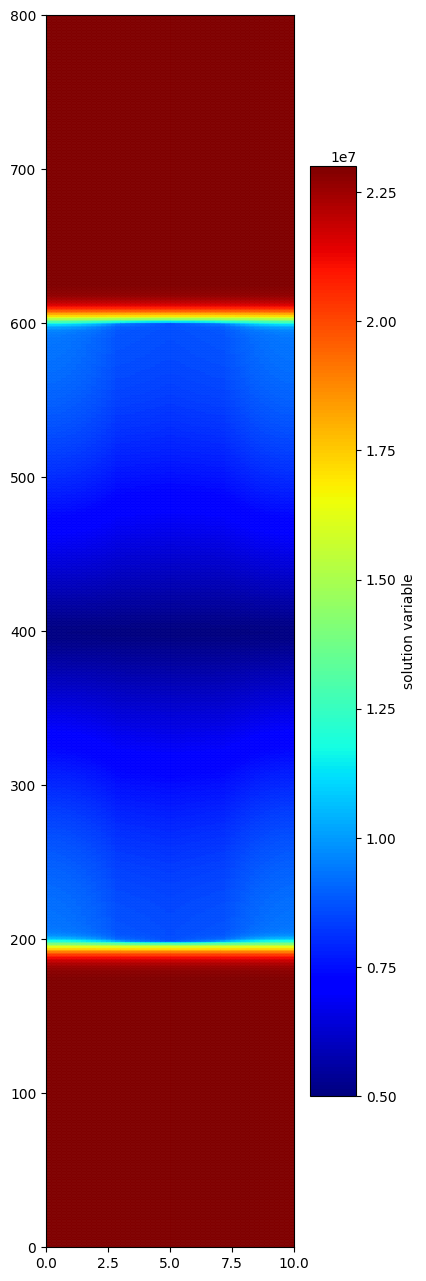

Время t = 170.0сут
Дебит, м^3/сут 0.4592132092800011


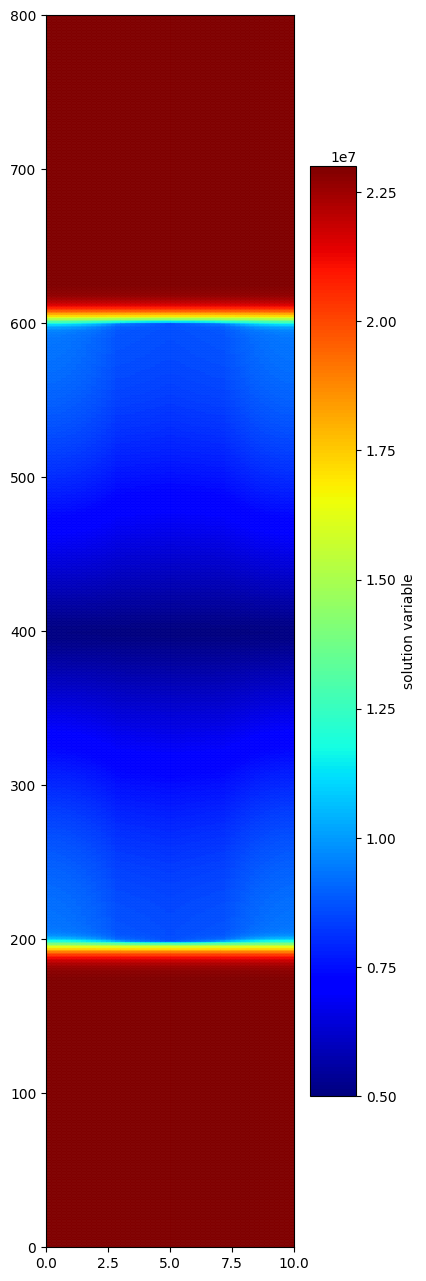

In [10]:
# Define the equation
D_nonlinear = 0
eq = fp.TransientTerm() == fp.DiffusionTerm(coeff=D*(1-D_nonlinear*phi.arithmeticFaceValue/Pstart))

Q = [] # Array of flow rates
timeStepDuration = 10*24*3600 # Time step duration
steps = 18 # Number of time steps
viewer = fp.Viewer(vars=phi) # Viewer for the variable
solver = fp.GeneralSolver(precon='lu') # Solver

from builtins import range
for step in range(steps):
    eq.solve(var=phi, dt=timeStepDuration) # Solve the equation
    viewer.plot()
    print('Time t = '+str(step*timeStepDuration/(24*3600))+' days')
    
    #----------------------------------------------------------------
    #------------------Flow Rate Calculation Block-------------------
    #----------------------------------------------------------------  
    # Step 1: Calculate pressure gradients
    ListGradSolution_X = [] 
    ListGradSolution_Y = [] 
    ListSolution = []
    a = mesh
    xa, ya = a.cellCenters
    k = 0
    for j in range(0, len(np.unique(xa))):
        for i in range(0, len(np.unique(ya))):
            ListGradSolution_X.append([xa[k], ya[k], phi.grad.value[0][k]])
            ListGradSolution_Y.append([xa[k], ya[k], phi.grad.value[1][k]])
            k = k + 1
    
    # Step 2: Calculate pressure gradients around the well
    # Calculate gradients in cells on the left face of the well
    y_temp = [399.5, 400.5]
    sum_grad_x = 0
    for score in ListGradSolution_X:
        for y in y_temp:
            if score[0] == 4.9 and score[1] == y:
                # Multiply by 2 because the gradient on the well boundary is calculated incorrectly
                sum_grad_x = sum_grad_x + 2*score[2]               
    # Calculate gradients in cells on the bottom face of the well
    x_temp = [5.000500000000001, 5.0015, 5.0024999999999995, 5.0035, 5.0045, 5.0055, 5.0065]
    sum_grad_y = 0
    for score in ListGradSolution_Y:
        for x in x_temp:
            if score[0] == x and score[1] == 398.5:
                # Multiply by 2 because the gradient on the boundary is calculated incorrectly
                # as the average between left-sided and right-sided derivatives
                # However, inside the well, the pressure gradient = 0
                sum_grad_y = sum_grad_y + 2*score[2]
  
    # Step 3: Calculate flow rates around the well  
    Sx = H*dx_Frac # Areas of cell faces around the well along x
    Sy = H*dy_SRV # Areas of cell faces around the well along y    
    Qx = -k_SRV*sum_grad_x*Sy/mu # Calculate flow from the left of the well    
    Qy = -k_Frac*sum_grad_y*Sx/mu # Calculate flow from the right of the well
    # Multiply by 2 because there are 4 sides
    Q.append([timeStepDuration*step/(24*3600), 2*(Qx+Qy)*24*3600])
    print('Flow rate, m^3/day '+str((Qx+Qy)*24*3600))

    # a = D*(1-1*D_nonlinear*phi.arithmeticFaceValue/Pstart)
    # a = (D*(1-D_nonlinear*phi.arithmeticFaceValue/Pstart)).value
    # print(a[a<3.3*10**(-6)].mean())
    # print(a[a>3.3*10**(-6)].mean())
    # print(a)

# Results

### Rate of well production data output

Дебит скважины


,Время (сут),Дебит (м^3/сут)
0,0.0,11.142200
1,10.0,6.917898
2,20.0,5.390519
3,30.0,4.471204
4,40.0,3.814486
5,50.0,3.309871
6,60.0,2.905733
7,70.0,2.572594
8,80.0,2.291950
9,90.0,2.051508


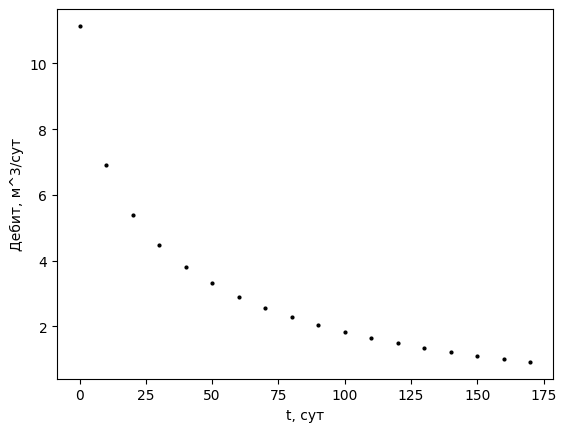

In [11]:
#----------------------------------------------------------------
#------------------Results Visualization Block-------------------
#----------------------------------------------------------------  

# Plot for the fracture (x=5.0015)
Coord = []
Value = []
for score in Q:
    Coord.append(score[0])
    Value.append(score[1])

print('Well flow rate')
plt.plot(Coord, Value, 'o', color='black', markersize=2)
plt.xlabel("t, days")
plt.ylabel("Flow rate, m^3/day")

# Create a DataFrame with flow rate data
df = pd.DataFrame(Q, columns=['Time (days)', 'Flow rate (m^3/day)'])
df

### Pressure data output

In [12]:
# For convenience, convert the solution array into a list format [x, y, p]
ListSolution = []  # Index starts from 0
a = mesh
xa, ya = a.cellCenters
k = 0
for j in range(0, len(np.unique(xa))):
    for i in range(0, len(np.unique(ya))):
        ListSolution.append([xa[k], ya[k], phi.value[k]])
        k = k + 1

,y (м),Давление (Па)
0,200.5,8591132
1,201.5,8589546
2,202.5,8587252
3,203.5,8584491
4,204.5,8581385
...,...,...
395,595.5,8608341
396,596.5,8611447
397,597.5,8614209
398,598.5,8616502


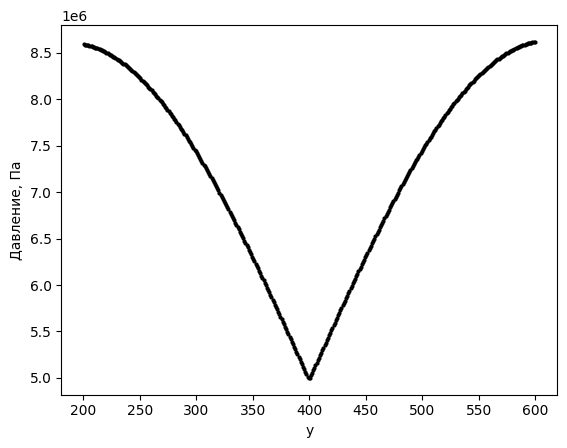

In [13]:
# Plot in the fracture zone (x = 5.0015)
filteredCoord = []
filteredValue = []
forPrint = []
for score in ListSolution:
    if score[0] == 5.0015 and score[1] < 600 and score[1] > 200:
        filteredCoord.append(score[1])
        filteredValue.append(score[2])
        forPrint.append([score[1], score[2]])

df = pd.DataFrame(forPrint, columns =['y (м)', 'Давление (Па)'])
display(df)

plt.xlabel("y")
plt.ylabel("Давление, Па")
plt.plot(filteredCoord, filteredValue, 'o', color='black', markersize=2)

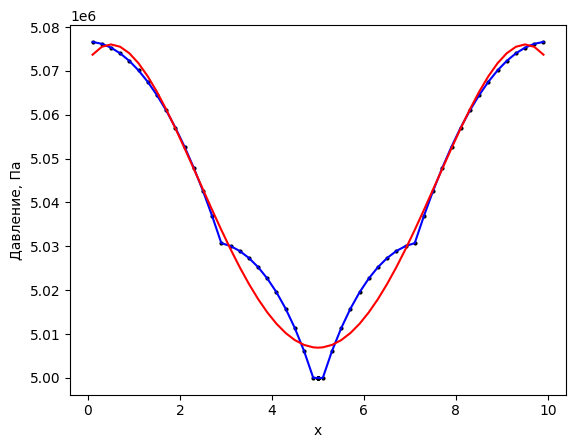

Аппроксимация: 
 p = 3356.2107908117673x^3 + -18378.628562450926x^2 + 15867.836021842819x + 5072300.604207244
Максимальное отклонение: 0.15392569382952803%
Метрика R^2: 0.9749364362529418


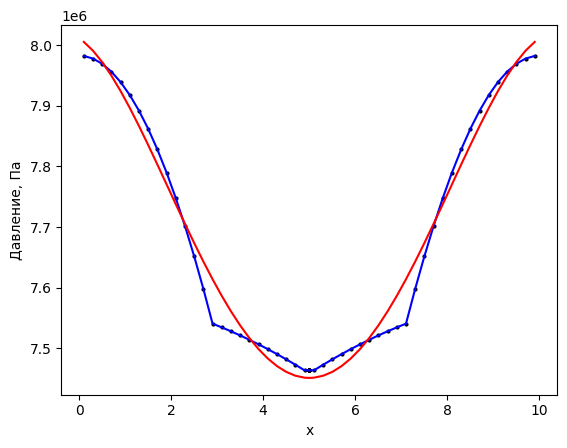

Аппроксимация: 
 p = 14030.367395843223x^3 + -65381.01960449851x^2 + -48232.982597754766x + 8010987.517749202
Максимальное отклонение: 0.9731175159319536%
Метрика R^2: 0.9832273609286327


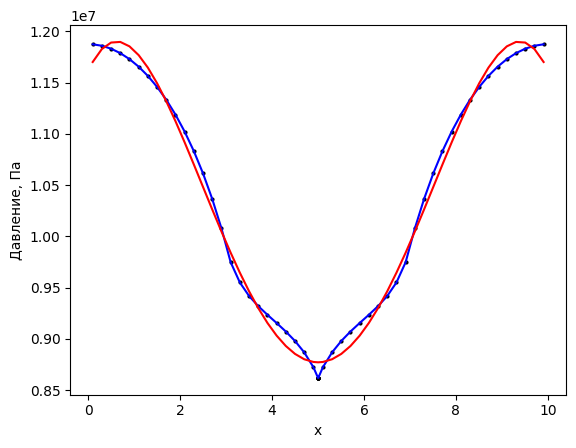

Аппроксимация: 
 p = 170047.81440375638x^3 + -950086.7038082407x^2 + 993219.3969327658x + 11610870.244717872
Максимальное отклонение: 1.7675862256118102%
Метрика R^2: 0.9925197508551717


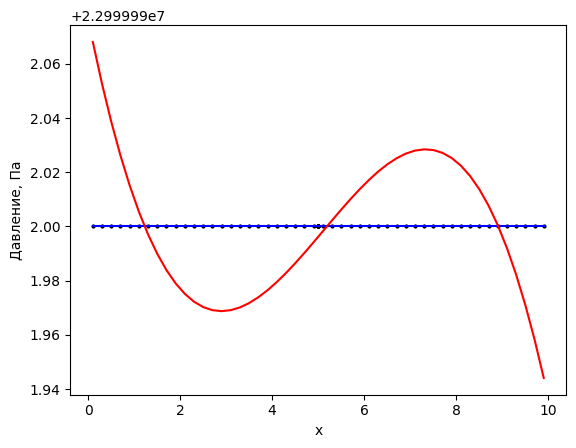

Аппроксимация: 
 p = -0.00128412092480121x^3 + 0.02035845662449627x^2 + -0.08525248547523653x + 22999992.07637401
Максимальное отклонение: 2.9587428780113795e-07%
Метрика R^2: -0.00045835099536617463


In [14]:
# Approximation in cross-sections at y = 400.5, 500.5, 600.5, 700.5
from scipy.optimize import curve_fit
import sklearn.metrics

yy = [400.5, 500.5, 600.5, 700.5]  # Cross-section y-coordinates

for i in yy:
    filteredCoord = []
    filteredValue = []
    for score in ListSolution:
        if score[1] == i:  # Filter for a specific y-coordinate
            filteredCoord.append(score[0])  # x-coordinates
            filteredValue.append(score[2])  # Pressure values

    # Convert to numpy arrays for calculation
    x = np.array(filteredCoord, dtype=np.float64)
    y = np.array(filteredValue, dtype=np.float64)

    # Polynomial fit of degree 4: p(x) = aa*x^4 + a*x^3 + b*x^2 + c*x + d
    [aa, a, b, c, d], _ = curve_fit(lambda x1, aa, a, b, c, d: aa * x1**4 + a * x1**3 + b * x1**2 + c * x1 + d, x, y)
    y1 = aa * x**4 + a * x**3 + b * x**2 + c * x + d  # Fitted polynomial values

    # Plot original values and fitted curve
    plt.xlabel("x")
    plt.ylabel("Pressure, Pa")
    plt.plot(filteredCoord, filteredValue, 'o', color='black', markersize=2, label="Original data")
    plt.plot(x, y, 'b', label="Original curve")
    plt.plot(x, y1, 'r', label="Fitted curve")
    plt.legend()
    plt.grid()
    plt.title(f"Pressure Approximation at y = {i}")
    plt.show()

    # Display fit information
    print(f"Approximation for y = {i}:")
    print(f"p(x) = {aa:.4e}x^4 + {a:.4e}x^3 + {b:.4e}x^2 + {c:.4e}x + {d:.4e}")
    print(f"Maximum deviation: {100 * max(abs((y1 - y) / y)):.2f}%")
    print(f"R^2 metric: {sklearn.metrics.r2_score(y, y1):.4f}\n")

# Data for comparison with tNavigator

In [41]:
# Calculation of average values
# Filtering values in the SRV zone
filteredCoord = []
filteredValue = []
for score in ListSolution:
    if score[1] < 600 and score[1] > 200 and score[0] > dx_MatrixLateral*nx_MatrixLateral and score[0] < FracXcoordStart:
        filteredCoord.append(score[1])
        filteredValue.append(score[2])
# Convert the array to numpy to avoid overflow
tmp = np.array(filteredValue, dtype=np.float64)
print('Average value in the SRV zone: ' + str(tmp.mean()))       

# Filtering values in the fracture zone
filteredCoord = []
filteredValue = []
for score in ListSolution:
    if score[1] < 600 and score[1] > 200 and score[0] > FracXcoordStart and score[0] < FracXcoordFinish:
        filteredCoord.append(score[1])
        filteredValue.append(score[2])                
# Convert the array to numpy to avoid overflow
tmp = np.array(filteredValue, dtype=np.float64)
print('Average value in the fracture zone: ' + str(tmp.mean())) 

# For the entire domain
print('Average value for the entire domain: ' + str(phi.value.mean()))

Среднее значение в зоне SRV 7257827.49725
Среднее значение в зоне трещины 7221191.5492857145
Среднее значение во всем кубе 15006735.200328948
